# LSLGA Groups

The purpose of this notebook is to build a group catalog from the parent sample of large galaxies.  Galaxies near one another (projected on the sky) must be analyzed at the same time, so we use a simple friends-of-friends algorithm to generate our group catalog.

## Preliminaries

In [1]:
import os
import numpy as np

In [91]:
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord

In [3]:
from pydl.pydlutils.spheregroup import spheregroup

In [4]:
%matplotlib inline

## Read the parent HyperLeda catalog

In [5]:
LSLGAdir = os.getenv('LSLGA_DIR')

In [6]:
ledafile = os.path.join(LSLGAdir, 'sample', 'leda-logd25-0.05.fits')
leda = Table.read(ledafile)
leda

GALAXY,PGC,RA,DEC,TYPE,OBJTYPE,MULTIPLE,D25,BA,PA,BMAG,IMAG,VHELIO
str28,str10,float64,float64,str4,str2,str1,float32,float32,float32,float32,float32,float32
PGC2456621,PGC2456621,0.0003,53.99049,,g,,34.5264,0.338844,48.0,17.24,-999.0,-999.0
PGC622563,PGC0622563,0.00045,-37.47607,,G,,17.7073,0.758578,128.0,17.75,15.84,-999.0
PGC1191650,PGC1191650,0.00045,1.33245,,g,,13.7452,0.812831,84.0,19.05,-999.0,-999.0
PGC639648,PGC0639648,0.00045,-36.19886,,G,,12.8278,0.891251,100.0,18.58,-999.0,-999.0
PGC1982072,PGC1982072,0.0006,32.1366,,G,,19.4156,0.74131,136.5,17.78,-999.0,-999.0
PGC535833,PGC0535833,0.0006,-44.57789,,G,,20.3306,0.588844,148.5,17.63,17.14,-999.0
PGC520795,PGC0520795,0.00075,-45.95405,,G,,20.3306,0.676083,24.7,17.54,15.5,-999.0
SDSSJ000000.16-001108.5,PGC4165833,0.00075,-0.18576,,G,,10.9182,0.912011,-999.0,18.89,17.5,58476.0
PGC1961515,PGC1961515,0.00075,31.7311,,G,,23.3427,0.616595,160.3,17.38,-999.0,-999.0


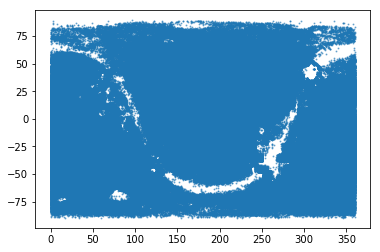

In [7]:
fig, ax = plt.subplots()
ax.scatter(leda['RA'], leda['DEC'], s=1, alpha=0.5)

In [8]:
these = (leda['RA'] > 200) * (leda['RA'] < 220) * (leda['DEC'] > 0) * (leda['DEC'] < 10.0)
leda = leda[these]
print(np.sum(these))

28476


## Run FoF with spheregroup

Identify groups using a simple angular linking length.  Then construct a catalog of group properties.

In [60]:
linking_length = 1.0 # [arcmin]

In [61]:
grp, mult, frst, nxt = spheregroup(leda['RA'], leda['DEC'], linking_length/60.0)

In [72]:
npergrp, _ = np.histogram(grp, bins=len(grp), range=(0, len(grp)))
nbiggrp = np.sum(npergrp > 1).astype('int')
nsmallgrp = np.sum(npergrp == 1).astype('int')
ngrp = nbiggrp + nsmallgrp

In [84]:
print('Found {} total groups, including:'.format(ngrp))
print('  {} groups with 1 member'.format(nsmallgrp))
print('  {} groups with 2-5 members'.format(np.sum( (npergrp > 1)*(npergrp <= 5) ).astype('int')))
print('  {} groups with 5-10 members'.format(np.sum( (npergrp > 5)*(npergrp <= 10) ).astype('int')))
print('  {} groups with >10 members'.format(np.sum( (npergrp > 10) ).astype('int')))

Found 24939 total groups, including:
  22176 groups with 1 member
  2737 groups with 2-5 members
  21 groups with 5-10 members
  5 groups with >10 members


## Populate the output group catalog

In [86]:
groupcat = Table()
groupcat.add_column(Column(name='GROUPID', dtype='i4', length=ngrp)) # unique ID number
groupcat.add_column(Column(name='GALAXY', dtype='S1000', length=ngrp))
groupcat.add_column(Column(name='NMEMBERS', dtype='i4', length=ngrp))
groupcat.add_column(Column(name='RA', dtype='f8', length=ngrp))  # average RA
groupcat.add_column(Column(name='DEC', dtype='f8', length=ngrp)) # average Dec
groupcat.add_column(Column(name='RADIUS', dtype='f4', length=ngrp))

In [144]:
smallindx = np.arange(nsmallgrp)

In [145]:
ledaindx = np.where(npergrp == 1)[0]
groupcat['RA'][smallindx] = leda['RA'][ledaindx]
groupcat['DEC'][smallindx] = leda['DEC'][ledaindx]
groupcat['NMEMBERS'][smallindx] = 1
groupcat['GALAXY'][smallindx] = leda['GALAXY'][ledaindx]
groupcat['RADIUS'][smallindx] = leda['D25'][ledaindx] / 2.0 # [arcsec]

In [88]:
bigindx = np.arange(nbiggrp) + nsmallgrp

In [141]:
for grpindx, indx in zip(bigindx, np.where(npergrp > 1)[0]):
    ledaindx = np.where(grp == indx)[0]
    _ra, _dec = leda['RA'][ledaindx], leda['DEC'][ledaindx]
    
    groupcat['RA'][grpindx] = np.mean(_ra)
    groupcat['DEC'][grpindx] = np.mean(_dec)
    groupcat['NMEMBERS'][grpindx] = len(ledaindx)
    groupcat['GALAXY'][grpindx] = ','.join(leda['GALAXY'][ledaindx])

    cc = SkyCoord(ra=_ra*u.degree, dec=_dec*u.degree)
    sep = []
    for onecc in cc[1:]:
        sep.append(cc.separation(onecc).arcsec.max())
    sep = np.array(sep)
    groupcat['RADIUS'][grpindx] = np.max( (sep.max(), np.max(leda['D25'][ledaindx] / 2)) )

In [142]:
groupcat['GROUPID'] = np.arange(ngrp)

In [146]:
groupcat

GROUPID,GALAXY,NMEMBERS,RA,DEC,RADIUS
int64,bytes1000,int32,float64,float64,float32
0,PGC3298787,1,200.00025,1.93209,5.58626
1,PGC3113329,1,200.0004,0.09401,6.41389
2,SDSSJ132000.21+064505.4,1,200.001,6.75155,6.12521
3,SDSSJ132000.27+061154.2,1,200.00115,6.1985,8.65209
4,SDSSJ132000.30+025943.9,1,200.0013,2.9955,11.9432
5,SDSSJ132000.57+034936.1,1,200.0025,3.82683,7.03269
6,PGC1365688,1,200.0043,9.47743,11.1461
7,2MASXJ13200113+0547200,1,200.0049,5.78902,6.41389
8,SDSSJ132001.33+050625.5,1,200.0055,5.1071,5.58626


ValueError: Invalid RGBA argument: 1

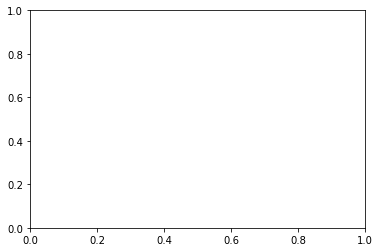

In [184]:
ww = np.where(groupcat['NMEMBERS'] > 2)[0]
fig, ax = plt.subplots()
ax.scatter(groupcat['RA'][ww], groupcat['DEC'][ww], c=groupcat['NMEMBERS'],
           cm = plt.cm.get_cmap('viridis'))
ax.colorbar()

GROUPID,GALAXY,NMEMBERS,RA,DEC,RADIUS
int64,bytes1000,int32,float64,float64,float32
17767,SDSSJ141505.45+092230.8,1,213.77265,9.37528,207.549


In [178]:
for ii, gal in enumerate(leda['GALAXY'].data):
    if 'SDSSJ141505.45+092230.8' in gal:
        print(ii)

19979


In [179]:
leda[19979]

GALAXY,PGC,RA,DEC,TYPE,OBJTYPE,MULTIPLE,D25,BA,PA,BMAG,IMAG,VHELIO
str28,str10,float64,float64,str4,str2,str1,float32,float32,float32,float32,float32,float32
SDSSJ141505.45+092230.8,PGC4544430,213.77265,9.37528,,G,,415.099,0.109648,55.5,17.97,16.61,47760.0


In [70]:
groupfile = os.path.join(LSLGAdir, 'sample', 'leda-logd25-0.05.fits')


22939

In [71]:
groupcat[22939]

GROUPID,RA,DEC,NMEMBERS,GALAXY
int64,float64,float64,int32,bytes1000
22939,205.554342857,2.24022952381,21,"PGC096969 ,PGC096971 ,2MASXJ13420905+0213354 ,PGC096943 ,PGC096972 ,PGC096973 ,PGC096942 ,PGC096975 ,PGC096976 ,PGC096977 ,PGC096944 ,PGC096953 ,PGC096979 ,PGC096948 ,PGC096952 ,PGC096951 ,PGC096947 ,PGC096983 ,PGC096984 ,PGC096985 ,PGC096987"


In [ ]:
groupcat[nsmallgrp:nsmallgrp+10]

In [ ]:
stop

In [ ]:
ii = np.where(npergrp == 2)[0]
print(ii)
np.where(grp == 9)

In [ ]:
npergrp[:10]

In [ ]:
len(grp), len(np.unique(grp))

In [ ]:
np.where(grp - np.arange(len(grp)) != 0)

In [ ]:
ww = np.where(grp == 8)[0]
leda[these][ww]

In [ ]:
np.sum(ngrp > 1)

In [ ]:
lega['']